<p style="font-size:36px;text-align:center"> <b>Personalized cancer diagnosis</b> </p>

<h1>>> Business Problem</h1>

<h2> Description</h2>
<p> Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/ </p>
<p> Data: Memorial Sloan Kettering Cancer Center (MSKCC)</p>
<p> Download training_variants.zip and training_text.zip from Kaggle.</p> 
<h6> Context:</h6>
<p> Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35336#198462</p>
<h6> Problem statement : </h6>
<h5>Classify the given genetic variations/mutations based on evidence from text-based clinical literature.</h5>

<h2> Real-world/Business objectives and constraints.</h2>
* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.

<h2> Assignments.</h2>
#### Task 3 : Apply FE techniques to reduce the test log-loss of your best model to less than 1


In [ ]:
import pandas as pd
from nltk.corpus import stopwords
import re
import time
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
#import scipy
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix

from sklearn.calibration import CalibratedClassifierCV
warnings.filterwarnings("ignore")


In [2]:
# This function plots the confusion, precision and recall matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A = (((C.T)/(C.sum(axis=1))).T)
    B = (C/C.sum(axis=0))
    
    labels = [1,2,3,4,5,6,7,8,9]
    
    # representing C in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    # representing B in heatmap format
    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing A in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
def predict_and_plot_confusion_matrix(train_x, train_y, test_x, test_y, cv_x, cv_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belonging to each class
    predict_y = sig_clf.predict_proba(train_x)
    print("The train log-loss is : ",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
    predict_y = sig_clf.predict_proba(cv_x)
    print("The cross validation log-loss is : ",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    predict_y = sig_clf.predict_proba(test_x)
    print("The test log-loss is : ",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

<h2> Reading Data</h2>
<h3> Reading Gene and Variation Data</h3>
<p>
    training/training_variants is a comma separated file containing the description of the genetic mutations used for training. <br>
    Fields are 
    <ul>
        <li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>
    </ul>

In [3]:
data = pd.read_csv('training/training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


<h3> Reading Text Data</h3>

In [4]:
# note the seprator in this file
data_text =pd.read_csv("training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


<h3> Preprocessing of text</h3>

In [5]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not float : # handles the nan records
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()

        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "

        data_text[column][index] = string

In [6]:
# text pre-processing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    nlp_preprocessing(row['TEXT'], index, 'TEXT')
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

Time took for preprocessing the text : 230.71096819337697 seconds


In [7]:
# merge both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [8]:
# replace the nan records in TEXT column with the value 'empty'
nanRows = np.where(result['TEXT'].isnull().values == True)[0]
print(nanRows)
for i in nanRows:
    result['TEXT'][i] = 'empty'

[1109 1277 1407 1639 2755]


<h3> Test, Train and Cross Validation Split</h3>

We split the data into train, test and cross validation data sets, preserving the ratio of class distribution in the original data set

In [9]:
# Splitting data into train, test and cross validation (64:20:16)
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [10]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


<h2> Vectorize/Featurize the data</h2>

In [11]:
# code for response coding of features with Laplace smoothing.

# this method returns a dict  which contains the probability array for each gene/variation
def get_gv_fea_dict(alpha, feature, df):
    value_count = train_df[feature].value_counts()
    gv_dict = dict()
    for i, denominator in value_count.items():
        vec = []
        for k in range(1,10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
        gv_dict[i]=vec
    return gv_dict

# Get gene/variation feature
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    value_count = train_df[feature].value_counts()
    
    gv_fea = []
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [38]:
# this method returns the indices of the most imp words according to tf-idf values
def getIndicesOf_topWords_From_TfIdf_Values(tf_idf_vect, final_tf_idf):
    feature_array = np.array(tf_idf_vect.get_feature_names())
    final_tf_idf_arr = final_tf_idf.toarray().sum(axis=0)
    
    topIndices = np.argsort(final_tf_idf_arr)[::-1]
    top_15k_indices = topIndices[0:15000]
    complete_most_imp_words = feature_array[topIndices]
    most_imp_words_subset = complete_most_imp_words[0:15000]
    
    return top_15k_indices,most_imp_words_subset

### We response-code the gene and variation feature and use tf-idf to vectorize the text feature (and choose the top 15k words)

In [13]:
# response code the gene and variation feature

# alpha is used for laplace smoothing
alpha = 1

# vectorize the gene feature
train_gene_feature_rc = np.array(get_gv_feature(alpha, "Gene", train_df))
test_gene_feature_rc = np.array(get_gv_feature(alpha, "Gene", test_df))
cv_gene_feature_rc = np.array(get_gv_feature(alpha, "Gene", cv_df))
print(train_gene_feature_rc.shape,cv_gene_feature_rc.shape,test_gene_feature_rc.shape)

# vectorize the variation feature
train_variation_feature_rc = np.array(get_gv_feature(alpha, "Variation", train_df))
test_variation_feature_rc = np.array(get_gv_feature(alpha, "Variation", test_df))
cv_variation_feature_rc = np.array(get_gv_feature(alpha, "Variation", cv_df))
print(train_variation_feature_rc.shape,cv_variation_feature_rc.shape,test_variation_feature_rc.shape)


(2124, 9) (532, 9) (665, 9)
(2124, 9) (532, 9) (665, 9)


In [14]:
# vectorize the text feature 
text_vectorizer = TfidfVectorizer(min_df=3)
train_text_feature = text_vectorizer.fit_transform(train_df['TEXT'])
# we use the same vectorizer that was trained on train data
cv_text_feature = text_vectorizer.transform(cv_df['TEXT'])
test_text_feature = text_vectorizer.transform(test_df['TEXT'])
print(train_text_feature.shape,cv_text_feature.shape,test_text_feature.shape)

(2124, 54084) (532, 54084) (665, 54084)


In [39]:
# Restrict the dimension of text feature to 15000(acc to tf-idf values)

# first we get the indices of the top 1000 words/features
top_15k_word_indices, top_15k_words = getIndicesOf_topWords_From_TfIdf_Values(text_vectorizer,train_text_feature)
#print(top_1000_word_indices[0:5])
print(top_15k_words[0:5])

# now we restrict the dimension of the vectorized text feature in train, cv and test to 1000 
# using the top words fetched above
train_text_feature_15k = train_text_feature[:,top_15k_word_indices]
cv_text_feature_15k = cv_text_feature[:,top_15k_word_indices]
test_text_feature_15k = test_text_feature[:,top_15k_word_indices]

print(train_text_feature_15k.shape,cv_text_feature_15k.shape,test_text_feature_15k.shape)

['mutations' 'brca1' 'cells' 'variants' 'fig']
(2124, 15000) (532, 15000) (665, 15000)


<h3> Now we stack the vectorized gene, variation and text features together to form our train, cv and test data-sets</h3>

In [40]:
# stack gene and variation first
train_gene_var = np.hstack((train_gene_feature_rc,train_variation_feature_rc))
test_gene_var = np.hstack((test_gene_feature_rc,test_variation_feature_rc))
cv_gene_var = np.hstack((cv_gene_feature_rc,cv_variation_feature_rc))
# now stack text(with all the tf-idf generated features)
train_x = hstack((train_gene_var, train_text_feature_15k))
test_x = hstack((test_gene_var, test_text_feature_15k))
cv_x = hstack((cv_gene_var, cv_text_feature_15k))

# don't forget to normalize every feature
'''
train_x = normalize(train_x, axis=0)
test_x = normalize(test_x, axis=0)
cv_x = normalize(cv_x, axis=0)
'''

train_y = train_df['Class'].values
test_y = test_df['Class'].values
cv_y = cv_df['Class'].values

print("(no of data points * no of features) in train data = ", train_x.shape)
print("(no of data points * no of features) in test data = ", test_x.shape)
print("(no of data points * no of features) in cross validation data =", cv_x.shape)

(no of data points * no of features) in train data =  (2124, 15018)
(no of data points * no of features) in test data =  (665, 15018)
(no of data points * no of features) in cross validation data = (532, 15018)


<h3> Hyperparameter Tuning</h3>

for alpha = 1e-06
Log Loss : 1.078615437294882
for alpha = 1e-05
Log Loss : 1.029247005371831
for alpha = 0.0001
Log Loss : 0.9830823059047762
for alpha = 0.001
Log Loss : 1.06265505892193
for alpha = 0.01
Log Loss : 1.1898482680901714
for alpha = 0.1
Log Loss : 1.3946763904675483
for alpha = 1
Log Loss : 1.5470053582957146
for alpha = 10
Log Loss : 1.5725054261655464
for alpha = 100
Log Loss : 1.57532030187775


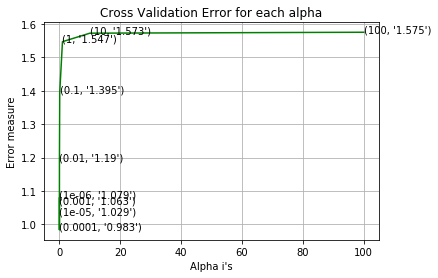

In [41]:
# logistic regression with rc gene, variation and tf-idf vectorized text(all words)
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

<h3> Testing the LR model with best hyperparameter </h3>

Best hyperparam :  0.0001
The train log-loss is :  0.630666387529592
The cross validation log-loss is :  0.9830823059047762
The test log-loss is :  0.9695819327529401
Number of mis-classified points : 0.3383458646616541
-------------------- Confusion matrix --------------------


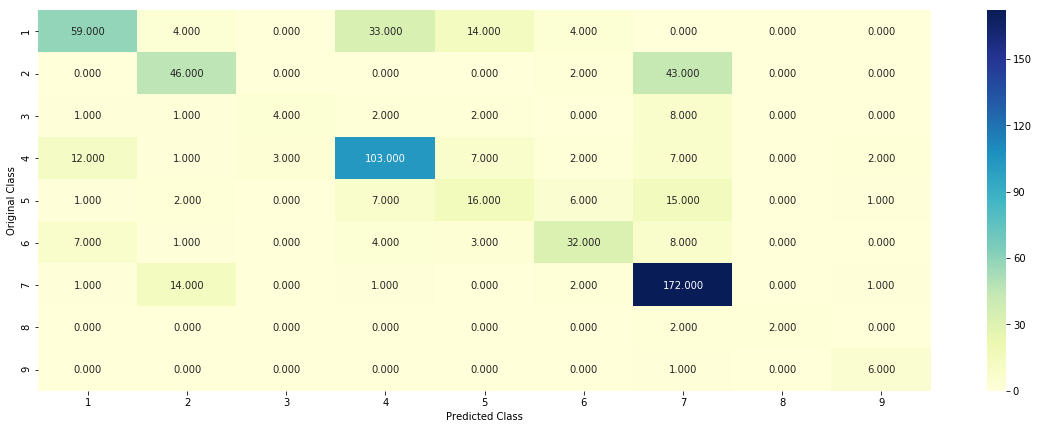

-------------------- Precision matrix (Columm Sum=1) --------------------


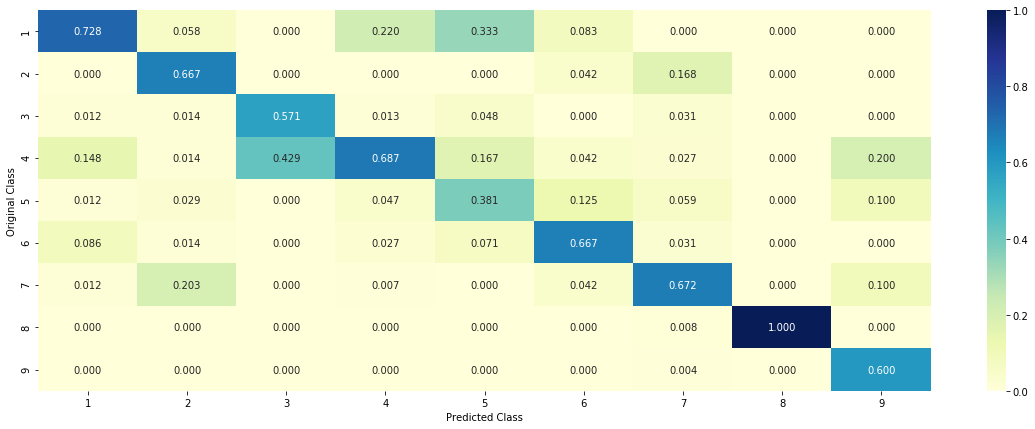

-------------------- Recall matrix (Row sum=1) --------------------


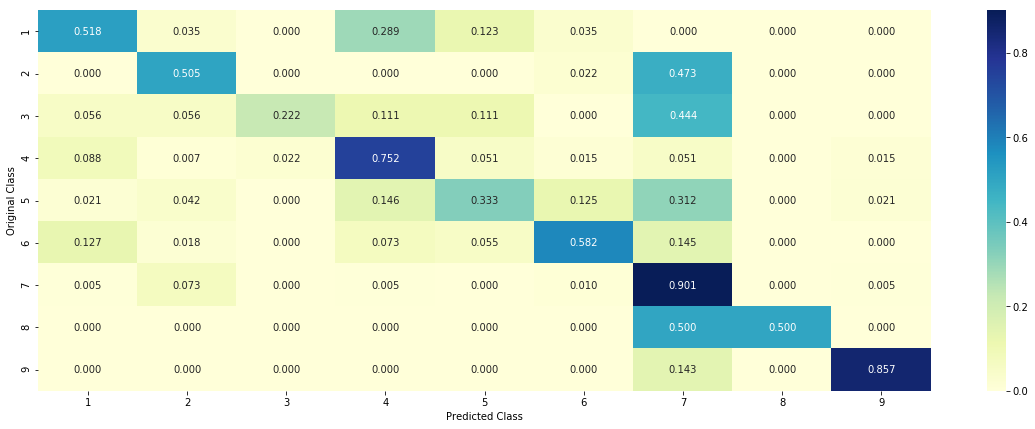

In [43]:
best_alpha = np.argmin(cv_log_error_array)
print('Best hyperparam : ',alpha[best_alpha])
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)

predict_and_plot_confusion_matrix(train_x, train_y, test_x, test_y, cv_x, cv_y, clf)


## Observation


| __Model__ | __train log-loss__ |__cv log-loss__ | __test log-loss__ | __misclassified points(%)__ |
|:---|:---:|:---:|:---:|:---:|
|   LR | 0.631 | 0.983  | 0.97 | 33.83  | 

### Note:
I tried  a few combinations of choosing the features, but the one mentioned above(response coding the gene and variation feature, tf-idf vectorizing the text feature and choosing the top 15k words) yielded the best performance metric and accuracy for me. 
In our EDA, we noticed that the gene feature is power-law distributed; so we applied log to the response-coded gene feature and then applied LR, but it didn't reduce the log-loss below the above metric. We tried some other mathematical transformations too but couldn't see any more performance improvement